In [1]:
# Copyright (c) 2015-2016, the authors (see AUTHORS.txt).
# Licensed under the BSD 3-clause license (see LICENSE.txt)
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook

import unittest
import deepgp
import GPy
import os
import h5py
import tables

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Bernoulli, MultivariateNormalTriL, Normal
from edward.util import rbf
from observations import crabs
from sklearn.decomposition import PCA
import scipy

base_path = os.path.dirname("__file__")

In [2]:
# def const(x):
#     x = tf.constant(x,dtype=tf.float32)
#     return x

# plt.subplots(2,3,figsize=(10,6))

# def build_toy_dataset(N, D, K, Ngrid = 100, prior_l=2, prior_sig_f=1, l=0.5, sig_f=1, sig_n=1e-1):
#     Nall = Ngrid + N
#     tgrid = np.linspace(-5, 5, num=N).reshape(-1,1)

#     sess = ed.get_session()
#     with sess.as_default():
#         Kprior = rbf(const(tgrid),lengthscale=const(prior_l),variance=const(prior_sig_f)).eval()

#     z_mu = np.zeros(N)
#     z_cov = Kprior + 1e-10*np.eye(N)
#     z = np.random.multivariate_normal(z_mu, z_cov).T.reshape(-1,1)
#     zgrid = np.linspace(z.min(), z.max(), num=Ngrid).reshape(-1,1)
#     zall = np.vstack((z,zgrid))

#     plt.subplot(2,3,1)
#     plt.imshow(Kprior)
#     plt.colorbar()
#     plt.subplot(2,3,2)
#     plt.plot(z)

#     with sess.as_default():
#         Kzall = rbf(const(zall),lengthscale=const(l),variance=const(sig_f)).eval()

#     Kz = Kzall[:N,:N]
#     xall = np.random.multivariate_normal(np.zeros(Nall), Kzall, D).T
#     x = xall[:N,:]
#     xgrid = xall[N:,:]
#     noise = np.random.randn(x.shape[0],x.shape[1])
#     x = x + sig_n*noise

#     plt.subplot(2,3,4)
#     plt.imshow(Kz)
#     plt.colorbar()
#     plt.subplot(2,3,5)
#     plt.imshow(np.cov(x))
#     plt.colorbar()
#     plt.subplot(2,3,6)
#     plt.plot(xgrid[:,:5])

#     return x,xgrid,z,zgrid,tgrid,Kz,Kprior

# N = 500  # number of data points, number of time points
# D = 200  # data dimensionality, number of neurons
# K = 1  # latent dimensionality

# x_true, xgrid, z_true, zgrid, tgrid, Kz_true, Kprior_true = build_toy_dataset(N, D, K)

# print("Number of data points N={}".format(N))
# print("Number of features D={}".format(D))
# print("Number of latent dimensions K={}".format(K))

# pca = PCA(n_components=1)
# z_init = pca.fit_transform(x_true)

# # visualize the covariance of Z
# plt.subplot(2,3,3)
# plt.plot(z_init)

# scipy.io.savemat('syn.mat',mdict={'x_true':x_true, 'xgrid':xgrid, 'z_true':z_true, 'zgrid':zgrid, 
#                                   'tgrid':tgrid, 'Kz_true':Kz_true, 'Kprior_true':Kprior_true})

<IPython.core.display.Javascript object>


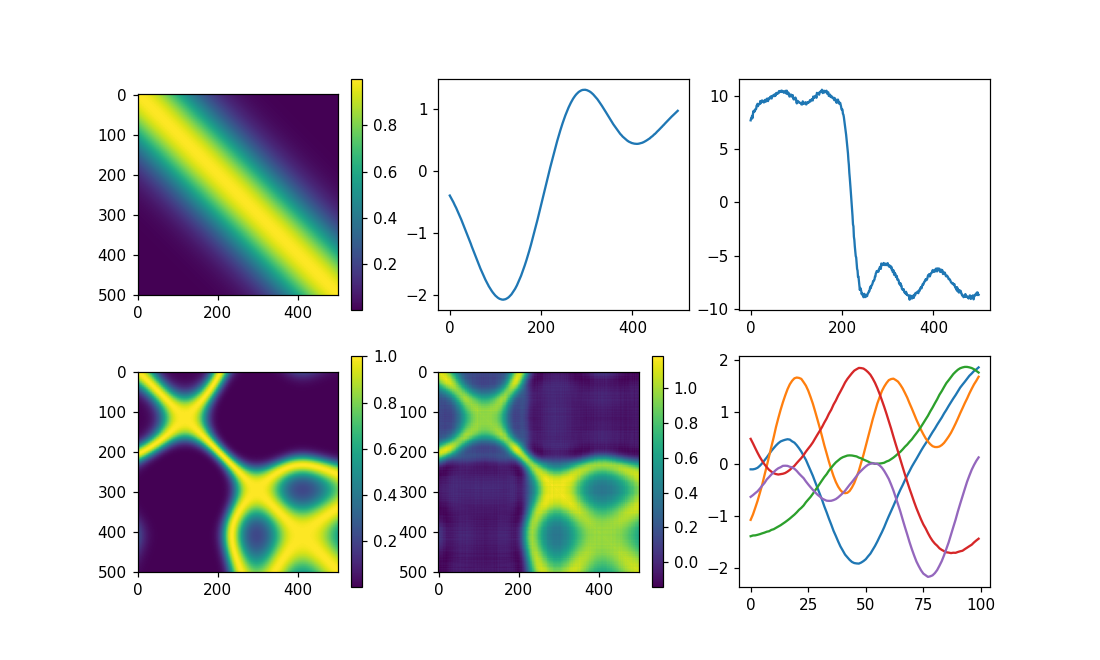

Number of data points N=500
Number of features D=200
Number of latent dimensions K=1


In [3]:
data = scipy.io.loadmat('syn.mat')
x_true = data['x_true']
xgrid = data['xgrid']
z_true = data['z_true']
zgrid = data['zgrid']
tgrid = data['tgrid']
Kz_true = data['Kz_true']
Kprior_true = data['Kprior_true']

N = x_true.shape[0]
D = x_true.shape[1]
K = z_true.shape[1]


pca = PCA(n_components=K)
z_init = pca.fit_transform(x_true)

plt.subplots(2,3,figsize=(10,6))
plt.subplot(2,3,1)
plt.imshow(Kprior_true)
plt.colorbar()
plt.subplot(2,3,2)
plt.plot(z_true)

plt.subplot(2,3,4)
plt.imshow(Kz_true)
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(np.cov(x_true))
plt.colorbar()
plt.subplot(2,3,6)
plt.plot(xgrid[:,:5])
plt.subplot(2,3,3)
plt.plot(z_init)

print("Number of data points N={}".format(N))
print("Number of features D={}".format(D))
print("Number of latent dimensions K={}".format(K))

In [4]:
X_var = 0.5*np.ones((N, D)) + 0.05*np.random.randn(N, D)
likelihood = GPy.likelihoods.Gaussian(variance = x_true.var()*0.01)

m = GPy.models.BayesianGPLVM(x_true, K, likelihood=likelihood, init='PCA', 
                             kernel=GPy.kern.RBF(K, lengthscale=1, ARD=False), 
                             num_inducing=np.min((x_true.shape[0], 50)))
print(m)
m['Gaussian_noise.variance'].fix()
m.optimize(max_iters=300)
print(m)
m['Gaussian_noise.variance'].constrain_positive()
m.optimize(max_iters=50)
Xr = m.X.mean
var = X_var
print(m)


Name : bayesian gplvm
Objective : 1218580.4073527583
Number of Parameters : 1053
Number of Optimization Parameters : 1053
Updates : True
Parameters:
  bayesian_gplvm.          |            value  |  constraints  |  priors
  latent_space.mean        |         (500, 1)  |               |        
  latent_space.variance    |         (500, 1)  |      +ve      |        
  inducing_inputs          |          (50, 1)  |               |        
  rbf.variance             |              1.0  |      +ve      |        
  rbf.lengthscale          |              1.0  |      +ve      |        
  Gaussian_noise.variance  |  0.0103946968861  |      +ve      |        

Name : bayesian gplvm
Objective : -78477.90736464794
Number of Parameters : 1053
Number of Optimization Parameters : 1052
Updates : True
Parameters:
  bayesian_gplvm.          |            value  |  constraints  |  priors
  latent_space.mean        |         (500, 1)  |               |        
  latent_space.variance    |         (500, 

In [5]:
def plot_kern(model):
    Kxx = model.kern.K(model.X.mean, model.X.mean)
    plt.subplots(2,2,figsize=(6,4))
    plt.subplot(2,2,1)
    plt.imshow(Kxx)
    plt.colorbar()

    Kuu = model.kern.K(model.Z, model.Z)+np.diag(model.Kuu_var)
    plt.subplot(2,2,2)
    plt.imshow(Kuu)
    plt.colorbar()

    Kxu = model.kern.K(model.X.mean, model.Z)
    plt.subplot(2,2,3)
    plt.imshow(Kxu)
    plt.colorbar()

    K1 = Kxu @ np.linalg.inv(Kuu) @ Kxu.T
    plt.subplot(2,2,4)
    plt.imshow(K1)
    plt.colorbar()
    return K1

(50, 1)


<IPython.core.display.Javascript object>


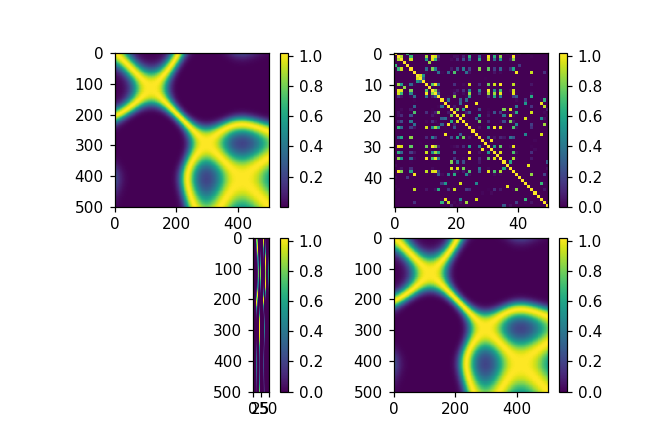

In [6]:
print(m.inducing_inputs.shape)
m.Kuu_var = np.ones((m.num_inducing,))*1e-6
Kz = plot_kern(m)

<IPython.core.display.Javascript object>


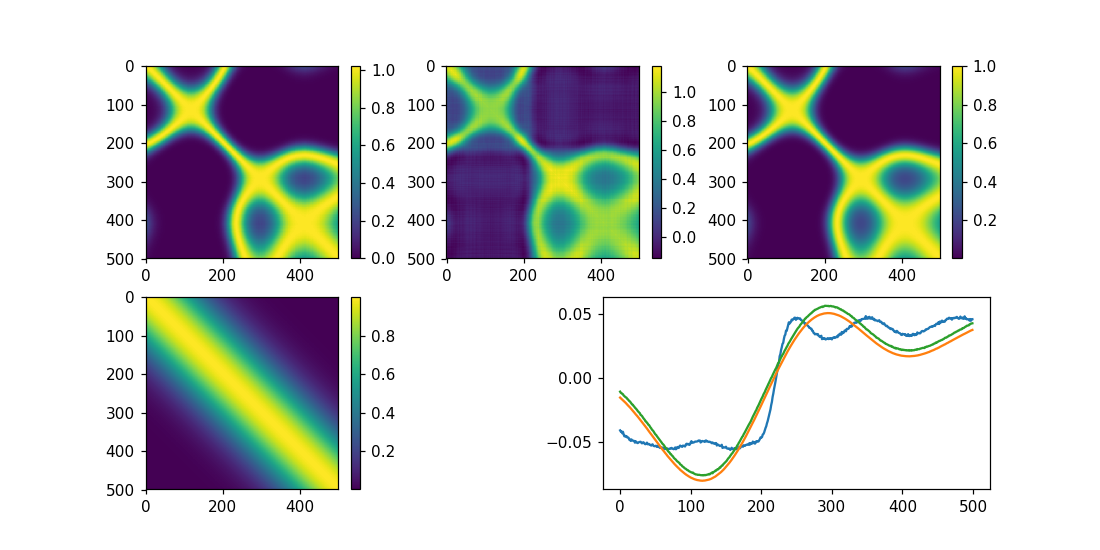

In [7]:
def match_z(x,z):
    cp = np.corrcoef(x.T,z.T)[0,1]
    cn = np.corrcoef(-x.T,z.T)[0,1]
    if cp<cn:
        return -x
    else:
        return x
    
plt.subplots(2,3,figsize=(10,5))
plt.subplot(2,3,1)
plt.imshow(Kz)
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(np.cov(x_true))
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow(Kz_true)
plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(Kprior_true)
plt.colorbar()
plt.subplot(2,2,4)
plt.plot(match_z(z_init/np.linalg.norm(z_init),z_true/np.linalg.norm(z_true)))
plt.plot(z_true/np.linalg.norm(z_true))
plt.plot(match_z(m.X.mean/np.linalg.norm(m.X.mean),z_true/np.linalg.norm(z_true)))
